## <font color='coral'>**Appel de l'environment** </font>

In [1]:
%reset -f
import ipywidgets as widgets
%matplotlib widget

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from IPython.display import clear_output
from RVutils import *
from scipy import special
import scipy.integrate as integrate
from scipy.misc import derivative

## For sliders
from ipywidgets import Layout, interact

## Set up rc
plt.rcParams['image.cmap'] = 'RdYlBu_r'
plt.rcParams['axes.formatter.limits'] = (-3,1)
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams.update({"axes.grid" : True})
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.markeredgewidth'] = 2.0
plt.rc('font',size=18)
me = (0.1,0.1) #Markevery

## <font color='coral'>**Chargement des données** </font>

In [8]:
data = np.loadtxt('data_exp/exp_profs_45333.dat')
data_q = np.loadtxt('data_exp/exp_profs_q_45333.dat')

data_exp = np.vstack((data,data_q))

param = ['rho','nustar_lowq','nustar_highq','eps','delta','q_lowq','q_highq']
data_dic  = {}
for ip,p in enumerate(param):
    data_dic[p] = data_exp[ip,:]

## <font color='coral'>**Defining collisional functions** </font>

In [9]:
# %% Collisions related functions
def Phi_v(v)   : return (2/(np.sqrt(np.pi))) * integrate.quad(lambda x: np.exp(-x**2),0,v)[0]
def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))
def nu_bar_v(v): return 0.75*np.sqrt(2*np.pi) * v**(-3) * (Phi_v(v) - G_v(v))
def nu_bar_u(u): return nu_bar_v(np.sqrt(u))

# %% Regime discrimination functions
def min_ap(x,y): return x*y/(x+y)
def max_ap(x,y): return x+y

## Some usefull parameters
I=(4 * 1.38 / np.pi)
sp2 = np.sqrt(np.pi/2)

res = 300
axe_theta = np.linspace(0,2*np.pi,res)
ulim=20

## kT, kE, kP
def kT_kE_kP_new(DoE, nustar, Nq):
    
    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            G0         +=0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    K_u       = 0
    K_hat_u   = 0
    K_tilde_u = 0
    
    d       = np.zeros(3)
    d_tilde = np.zeros(3)
    d_hat   = np.zeros(3)
    
    vres    = 100
    for u in np.linspace(0.01,20,vres):
        K_u       = sp2 * np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u))
        K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\
                        (32/9)* G1  \
                        +2*(1/(Nq))*DoE**2 * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)))
        K_hat_u   = sp2 * Nq * np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u)))
        
        for n in range(3):
            d[n]       += (u-1.5)**n * K_u
            d_tilde[n] += (u-1.5)**n * K_tilde_u 
            d_hat[n]   += (u-1.5)**n * K_hat_u 

    Delta = (d[0] + d_tilde[0])*(d[0] + d_hat[0])-d[0]**2 
            
    k_T = (d[0] * d_tilde[1] - d[1] * d_tilde[0])  /Delta
    k_E = ((d[0] + d_hat[0])*(d[1] + d_tilde[1]) - d[0]*d[1]) /Delta
    k_P = 1 + k_T - k_E
    return k_T, k_E, k_P

## <font color='coral'>**Plot profiles** </font>

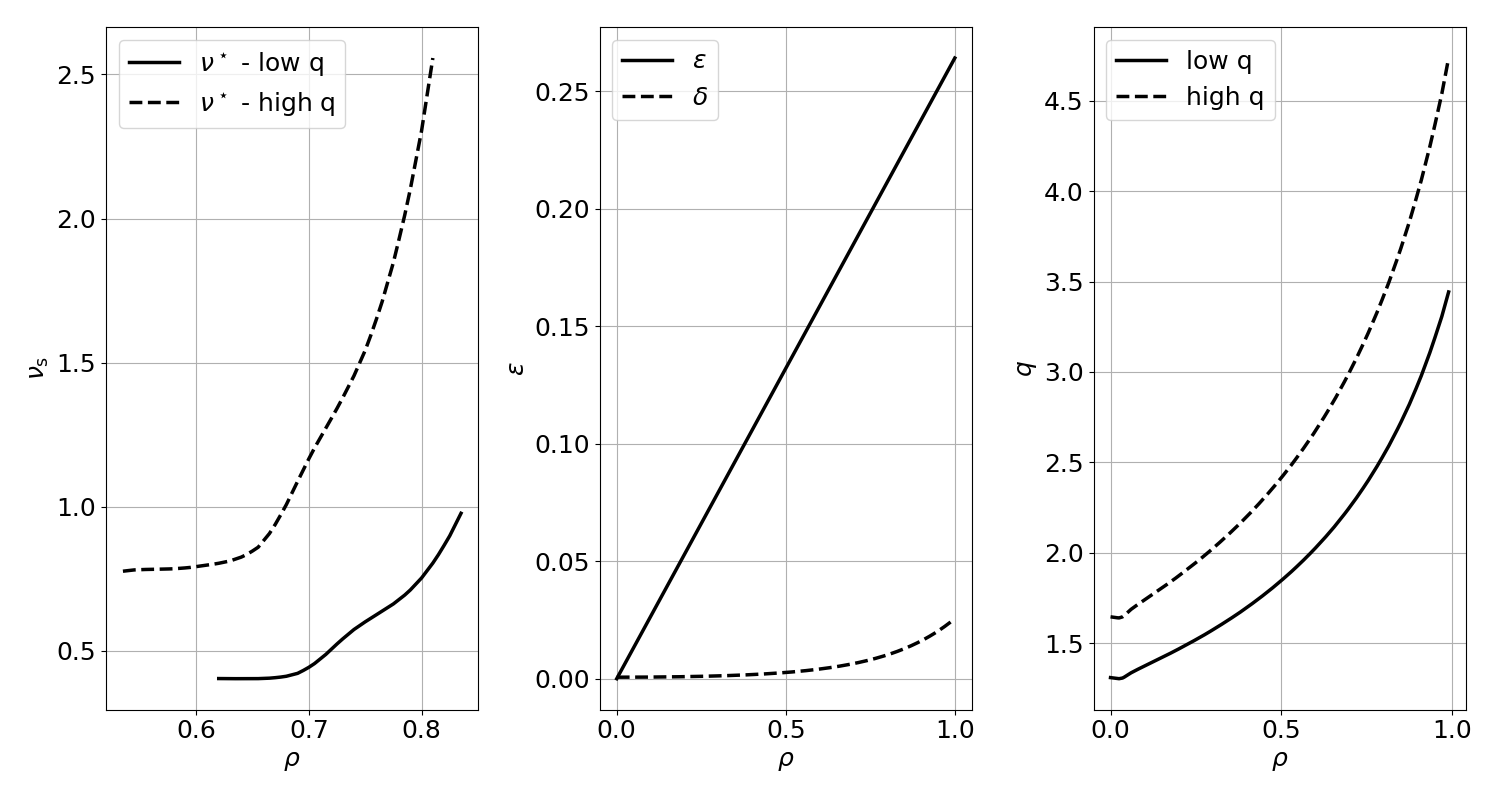

In [14]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


ax1.plot(data_dic['rho'],data_dic['nustar_lowq'],'k-',label=r'$\nu^\star$ - low q')
ax1.plot(data_dic['rho'],data_dic['nustar_highq'],'k--',label=r'$\nu^\star$ - high q')
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$\nu_{\rm s}$')
ax1.legend(loc='best')

ax2.plot(data_dic['rho'],data_dic['eps'],'k-',label=r'$\epsilon$')
ax2.plot(data_dic['rho'],data_dic['delta'],'k--',label=r'$\delta$')
ax2.set_xlabel(r'$\rho$')
ax2.set_ylabel(r'$\epsilon$')
ax2.legend(loc='best')

ax3.plot(data_dic['rho'],data_dic['q_lowq'],'k-',label=r'low q')
ax3.plot(data_dic['rho'],data_dic['q_highq'],'k--',label=r'high q')
ax3.set_xlabel(r'$\rho$')
ax3.set_ylabel(r'$q$')
ax3.legend(loc='best')



fig.tight_layout()

## <font color='coral'>**Calculating $k_E$ profile for experimental discharges** </font>

In [16]:
kE_ar1 = np.zeros(len(data_dic['rho']))
kE_ar2 = np.zeros(len(data_dic['rho']))

N=18

for il,(rho,nu1,nu2,eps,delta,q1,q2) in enumerate(zip(data_dic['rho'],data_dic['nustar_lowq'],data_dic['nustar_highq'],data_dic['eps'],data_dic['delta'],data_dic['q_lowq'],data_dic['q_highq'])):
    print(nu1,nu2)
    if not(np.isnan(rho) or np.isnan(nu1) or np.isnan(nu2) or np.isnan(eps) or np.isnan(delta) or np.isnan(q1) or np.isnan(q2)):
        kE_ar1[il]=kT_kE_kP_new(delta/eps,nu1,N*q1)[1]
        kE_ar2[il]=kT_kE_kP_new(delta/eps,nu2,N*q2)[1]
    print(il)
    print(kE_ar1[il])
    print(kE_ar2[il])

#print(kE_ar1)


nan nan
0
0.0
0.0
nan nan
1
0.0
0.0
nan nan
2
0.0
0.0
nan nan
3
0.0
0.0
nan nan
4
0.0
0.0
nan nan
5
0.0
0.0
nan nan
6
0.0
0.0
nan nan
7
0.0
0.0
nan nan
8
0.0
0.0
nan nan
9
0.0
0.0
nan nan
10
0.0
0.0
nan nan
11
0.0
0.0
nan nan
12
0.0
0.0
nan nan
13
0.0
0.0
nan nan
14
0.0
0.0
nan nan
15
0.0
0.0
nan nan
16
0.0
0.0
nan nan
17
0.0
0.0
nan nan
18
0.0
0.0
nan nan
19
0.0
0.0
nan nan
20
0.0
0.0
nan nan
21
0.0
0.0
nan nan
22
0.0
0.0
nan nan
23
0.0
0.0
nan nan
24
0.0
0.0
nan nan
25
0.0
0.0
nan nan
26
0.0
0.0
nan nan
27
0.0
0.0
nan nan
28
0.0
0.0
nan nan
29
0.0
0.0
nan nan
30
0.0
0.0
nan nan
31
0.0
0.0
nan nan
32
0.0
0.0
nan nan
33
0.0
0.0
nan nan
34
0.0
0.0
nan nan
35
0.0
0.0
nan nan
36
0.0
0.0
nan nan
37
0.0
0.0
nan nan
38
0.0
0.0
nan nan
39
0.0
0.0
nan nan
40
0.0
0.0
nan nan
41
0.0
0.0
nan nan
42
0.0
0.0
nan nan
43
0.0
0.0
nan nan
44
0.0
0.0
nan nan
45
0.0
0.0
nan nan
46
0.0
0.0
nan nan
47
0.0
0.0
nan nan
48
0.0
0.0
nan nan
49
0.0
0.0
nan nan
50
0.0
0.0
nan nan
51
0.0
0.0
nan nan
52
0.0
0.0
nan

C:\Users\RV273815\AppData\Local\Temp\ipykernel_12152\3259788412.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))


124
1.3923754075360635
1.395158532667797
0.40342036 0.80769559
125
1.4097389697320408
1.4072937324505537
0.40318907 0.81174567
126
1.4282618699928689
1.4193718349423323
0.40323357 0.81833237
127
1.4477847900183476
1.4306316982125191
0.40329586 0.82508271
128
1.4682444164188087
1.441691575214492
0.40333333 0.8344839
129
1.489539538866739
1.4516628796400015
0.40334742 0.84638
130
1.5115414278818045
1.4605558452656615
0.40343091 0.85935728
131
1.5340637501637597
1.4688570936527565
0.40420829 0.88314638
132
1.5566134869729935
1.4733799362858935
0.40498567 0.90693548
133
1.5794279726951788
1.4777374902579232
0.40666506 0.93758097
134
1.6014569345503558
1.479757862371957
0.40879546 0.97165466
135
1.6230035491652623
1.4807099117731422
0.4116306 1.0072471
136
1.643671207699315
1.4812718923417956
0.41666805 1.0475857
137
1.6617010891949298
1.4806233238334936
0.4217055 1.0879243
138
1.6793896279149276
1.4801360597366386
0.43166907 1.1273388
139
1.6913258433796343
1.4800937966892256
0.44272733 1.

C:\Users\RV273815\AppData\Local\Temp\ipykernel_12152\3259788412.py:8: RuntimeWarning: invalid value encountered in double_scalars
  def min_ap(x,y): return x*y/(x+y)
C:\Users\RV273815\AppData\Local\Temp\ipykernel_12152\3259788412.py:45: RuntimeWarning: invalid value encountered in double_scalars
  K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\


163
1.756278970928543
nan
0.86588862 -inf
164
1.7487942151535882
nan
0.89901946 -inf
165
1.741219327059733
nan
0.93805983 -inf
166
1.7313032178334467
nan
0.97710019 -inf
167
1.7220951247764664
nan
-inf -inf
168
nan
nan
-inf -inf
169
nan
nan
-inf -inf
170
nan
nan
-inf -inf
171
nan
nan
-inf -inf
172
nan
nan
-inf -inf
173
nan
nan
-inf -inf
174
nan
nan
-inf -inf
175
nan
nan
-inf -inf
176
nan
nan
-inf -inf
177
nan
nan
-inf -inf
178
nan
nan
-inf -inf
179
nan
nan
-inf -inf
180
nan
nan
-inf -inf
181
nan
nan
-inf -inf
182
nan
nan
-inf -inf
183
nan
nan
-inf -inf
184
nan
nan
-inf -inf
185
nan
nan
-inf -inf
186
nan
nan
-inf -inf
187
nan
nan
-inf -inf
188
nan
nan
-inf -inf
189
nan
nan
-inf -inf
190
nan
nan
-inf -inf
191
nan
nan
-inf -inf
192
nan
nan
-inf -inf
193
nan
nan
-inf -inf
194
nan
nan
-inf -inf
195
nan
nan
-inf -inf
196
nan
nan
-inf -inf
197
nan
nan
-inf -inf
198
nan
nan
nan nan
199
0.0
0.0
nan nan
200
0.0
0.0


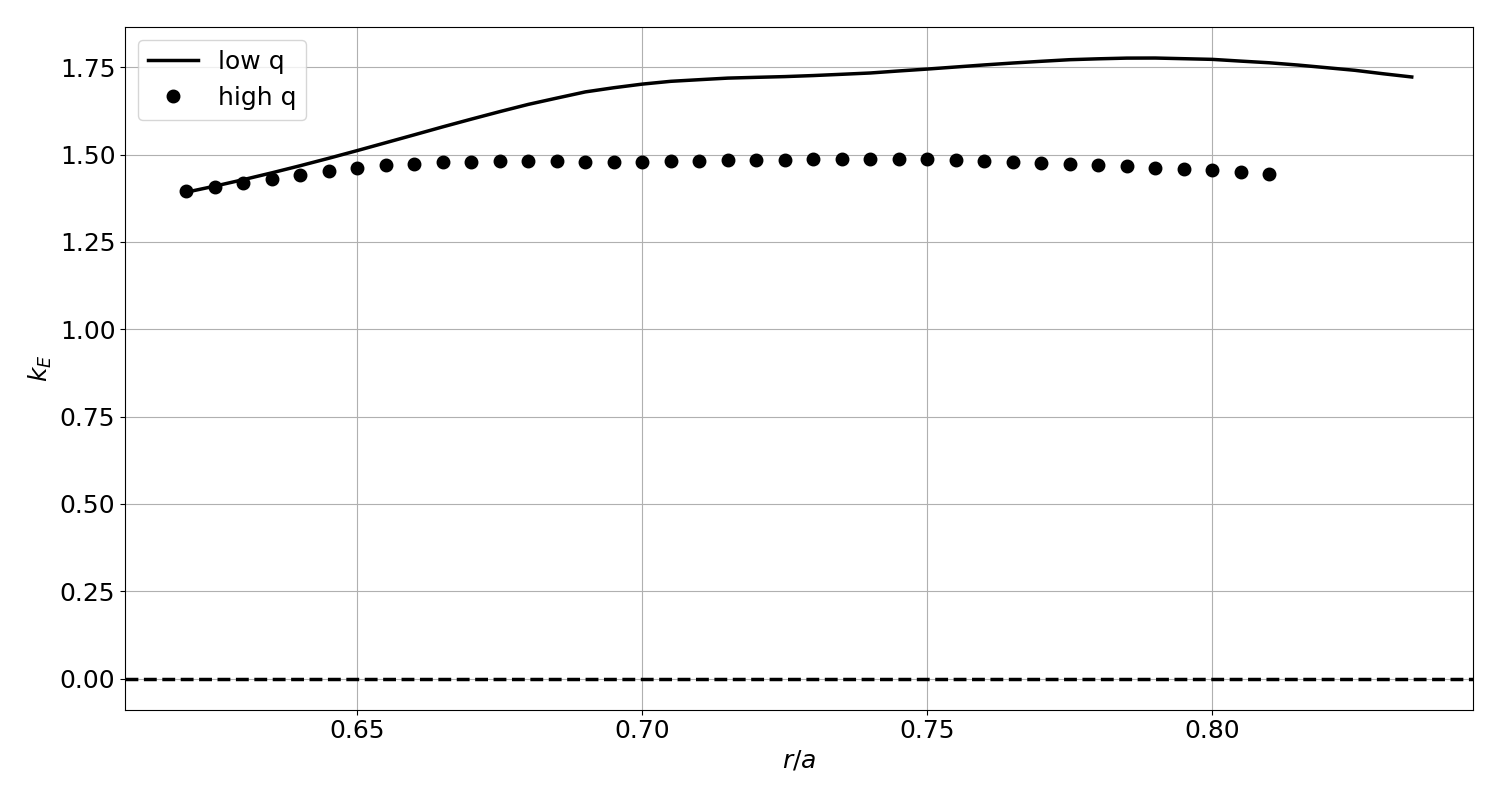

In [23]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar1[kE_ar1>0],'k-',label=r'low q')
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar2[kE_ar1>0],'ko',label=r'high q')
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$k_E$')
ax1.legend(loc='best')

ax1.axhline(0.0,color='k',linestyle='--')

fig.tight_layout()

## <font color='coral'>**(Maybe not useful) Differentiating TS and WEST ripple** </font>

In [ ]:
def calculate_ripple_amplitude_TS(rho, theta):
    # Paramètres Tore Supra
    R0    = 2.3946       #Grand rayon
    Eps   = 3.2          #Rapport d'aspect
    a     = R0/Eps       #Petit rayon
    N     = 18           #Nombre de bobines
    Eps_b = 1.267/2.3946 #Rapport du diamètre moyen des bobines sur le grand rayon
    L0 = 0.5*R0* ( 1 - np.sqrt(1 - 2*(Eps_b**2) ) )   #cf Rapport de stage Varennes 2018
    delta_n = 9.8559e-5 #Paramètre ajusté pour coller au mieux à la thèse de Grua pour N=18

    # Calcul de l'amplitude ripple
    r = rho*a
    cos = np.cos(theta)
    R = R0 + r*cos
    rprime = np.sqrt( 2*(R0-L0)* ( R - np.sqrt(R**2 - r**2 - L0**2 - 2*r*L0*cos) ) )
    ripple_TS_amp = delta_n * special.iv(0, N * rprime / (R0-L0) ) #special.iv(0,x) : fonction de Bessel modifiée de première espèce d'ordre 0
    
    return ripple_TS_amp

def TS_ripple_FSavg(rho):
    # Paramètres Tore Supra
    R0    = 2.3946       #Grand rayon
    Eps   = 3.2          #Rapport d'aspect
    a     = R0/Eps       #Petit rayon
    N     = 18           #Nombre de bobines
    Eps_b = 1.267/2.3946 #Rapport du diamètre moyen des bobines sur le grand rayon
    L0 = 0.5*R0* ( 1 - np.sqrt(1 - 2*(Eps_b**2) ) )   #cf Rapport de stage Varennes 2018
    delta_n = 9.8559e-5 #Paramètre ajusté pour coller au mieux à la thèse de Grua pour N=18

    # Calcul de l'amplitude ripple
    r = rho*a
    theta_ar = np.linspace(0,2*np.pi,100)
    ripple_TS_amp = np.zeros(len(theta_ar))
    for ith,theta in enumerate(theta_ar):
        cos = np.cos(theta)
        R = R0 + r*cos
        rprime = np.sqrt( 2*(R0-L0)* ( R - np.sqrt(R**2 - r**2 - L0**2 - 2*r*L0*cos) ) )
        ripple_TS_amp[ith] = delta_n * special.iv(0, N * rprime / (R0-L0) ) 
    return np.mean(ripple_TS_amp,axis=0)

print(TS_ripple_FSavg(0.5))

rho_ar = np.linspace(0.1,1.0,100)
